In [1]:
import os, glob, string, re
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt

import numpy as np
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
%matplotlib inline

Using TensorFlow backend.


Downloading the data from the previous cleaning part

In [2]:
wordCountYear = pd.read_csv('wordCountYear_Clean_v3.csv',index_col=0)
wordCountYear.head()

,Unnamed: 1,a,aar,aarau,aax,aay,abandonné,abattu,abb,abbaye,...,évéque,évêque,êles,êlre,êtr,îes,île,œil,œuvre,œx
1798-02-01,0.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0
1798-03-01,0.0,26.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0
1798-04-01,0.0,19.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,...,0.0,0.0,0.0,0.0,126.0,0.0,0.0,0.0,0.0,0.0
1798-05-01,0.0,40.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,180.0,0.0,0.0,0.0,0.0,0.0
1798-06-01,0.0,21.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,156.0,0.0,0.0,0.0,0.0,0.0


Here we process the time index of the dataframe

In [3]:
wordCountYear.index = pd.to_datetime(wordCountYear.index)

We save the index


In [4]:
yearIndex = wordCountYear.index.values



Now we pass the dataset into a frequency representation. As seen before.

In [5]:
wordCountYear['Total Words'] = wordCountYear.sum(axis=1).values

In [6]:
wordNorm = wordCountYear.divide(wordCountYear['Total Words'],axis=0)

Here we show the visualization of the word 'noël' that we are going to predict later.

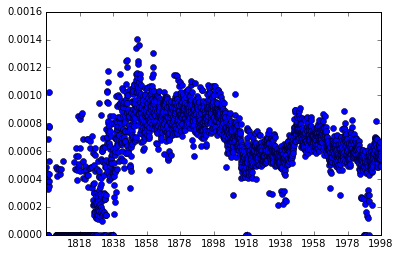

In [7]:
plt.plot_date(yearIndex,wordNorm['vrai'].values)

We select this time serie for the word 'noël' and we reshape it in array form that suit the following of our processing

In [8]:
time_serie_noel = wordNorm['politique']

Here we make a copy of the time serie and we replace all the 0 value by NaN. This is required for the interpolation that we will apply soon after.

In [9]:
serie_nan = time_serie_noel.copy()

In [10]:
serie_nan[serie_nan == 0] = np.nan

Now we apply interpolation. We assume that the non occurence of a words during a month while it was present before and after this month can be considered to be a kind of error due to the inherent essence of newspaper where words can be eclispsed by other due to important event even though the trend is that the word is used.

In [11]:
serie_inter = serie_nan.interpolate()

And we rechange back the NaN value that have not been interpolated (if not beetween real values).

In [12]:
serie_final = serie_inter.fillna(0)

We can see the results

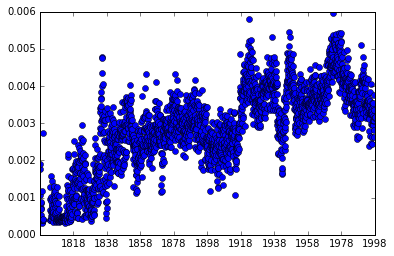

In [13]:
plt.plot_date(yearIndex,serie_final)

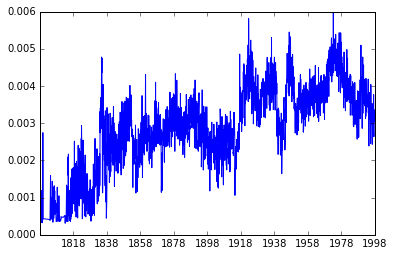

In [14]:
plt.plot(serie_final)

# Time serie prediction

Our goal is to predict the future of the time serie to a reasonable horizon. One year in the future seems to be a first reasonable objective. We will use techniques based on the arima (auto-regressive integrated moving average) model for time series prediction.

As our time series are very "noisy" we decided to smooth them by using a moving average first. Thus it is the rolling mean of our data that we will try to predict and not the raw time series. We do that because the resulting time series are more easily predicted and because we believe this processing is relevant for reducing the noise that arise from the inherent form factor of the newspaper release.

Here is the time serie for the word "politique" after a moving average is applied.

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=16,center=False).mean()
  if __name__ == '__main__':


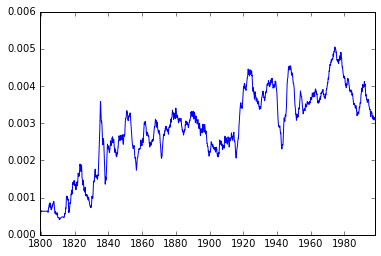

In [23]:
rolmean = pd.rolling_mean(serie_final, window=16)
rolmean.dropna(inplace=True) #This is needed to remove the nan that appears at the beginning and the end
plt.plot(rolmean)




Hopefully this smoother serie will be easier to predict than the original.

Now in the arima model, we need to have stationnary time series. This means that the mean and the variance of the time serie should not be in function of time. Also the covariance of between a term at time t and another term at time t + m should not be in function of time.

To see if a time serie is stationnary there are two ways. We can inspect the graph of the serie visually or we can use some statistical test. 

Visually we can directly see that our serie is not stationnary. There is a clear increasing trend which means the mean is dependant of the time. We can also spot some seasonal component.

To confirm that we will perfom a Dickey fuller test.


In [38]:
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm

Below is the definition of a function for testing the stationarity of a time serie. Of course we already know from previous visualization that the serie is not stationary but we want to make a better visualization of it as well as a statistical test. We use the Dickey-fuller test for stationarity

In [39]:
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=48)
    rolstd = pd.rolling_std(timeseries, window=48)

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

We test our time serie (the rolling mean).

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:4: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=48,center=False).mean()
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:5: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=48,center=False).std()


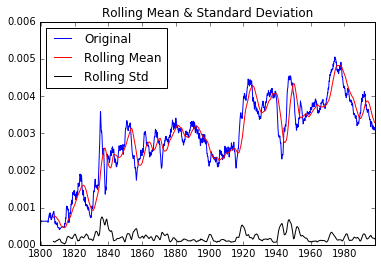

Results of Dickey-Fuller Test:
Test Statistic                   -2.945830
p-value                           0.040272
#Lags Used                       24.000000
Number of Observations Used    2313.000000
Critical Value (5%)              -2.862790
Critical Value (1%)              -3.433180
Critical Value (10%)             -2.567436
dtype: float64


In [40]:
test_stationarity(rolmean)

Surprisingly the test show that the serie is stationnary for a 10% and 5% critical value (as seen by the test statistic value which is bigger than those value in absolute value). This may be due to the fact that the serie appears to have a trend but if we look with more granularity the serie appears flat. The change in mean would thus be very slow and not detected. 

Still we will try to increase stationnarity by substracting a shifted value or the serie to itself.

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:4: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=48,center=False).mean()
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:5: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=48,center=False).std()


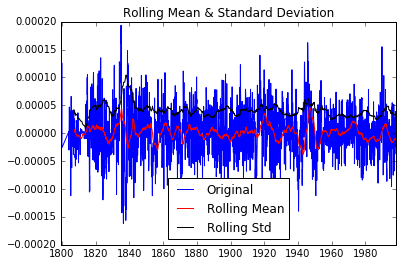

Results of Dickey-Fuller Test:
Test Statistic                -7.573225e+00
p-value                        2.805267e-11
#Lags Used                     2.300000e+01
Number of Observations Used    2.313000e+03
Critical Value (5%)           -2.862790e+00
Critical Value (1%)           -3.433180e+00
Critical Value (10%)          -2.567436e+00
dtype: float64


In [41]:
first_difference = rolmean - rolmean.shift(1)
first_difference.dropna(inplace=True)
test_stationarity(first_difference)

We can see that we increased the stationnarity (the test statistic value is bigger in absolute value) now it is even bigger than the 1% critical value.

In order to increase again the stationnarity and take into accound the seasonality of our serie, we substract the first difference that we just computed with a shifted version of itself by 12 month. 

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:4: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=48,center=False).mean()
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:5: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=48,center=False).std()


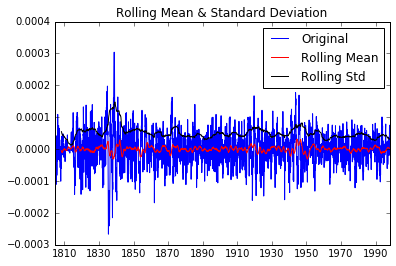

Results of Dickey-Fuller Test:
Test Statistic                -1.519714e+01
p-value                        5.898970e-28
#Lags Used                     2.700000e+01
Number of Observations Used    2.297000e+03
Critical Value (5%)           -2.862799e+00
Critical Value (1%)           -3.433200e+00
Critical Value (10%)          -2.567440e+00
dtype: float64


In [42]:
seasonal_difference = first_difference - first_difference.shift(12)
seasonal_difference.dropna(inplace=True)
test_stationarity(seasonal_difference)

Now the serie is stationary.


Autocorrelation for the seasonnal_difference

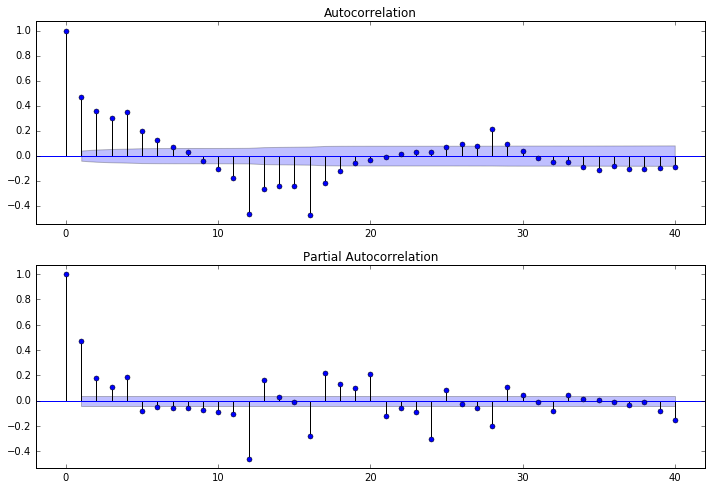

In [27]:

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(seasonal_difference.iloc[13:], lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(seasonal_difference.iloc[13:], lags=40, ax=ax2)

Now we can build the model. We use a SARIMAX model that will accounnt for seasonality.

In [53]:
mod = sm.tsa.statespace.SARIMAX(rolmean, trend='n', order=(0,1,1), seasonal_order=(0,1,1,12))
results = mod.fit()
print(results.summary())

//anaconda/lib/python3.5/site-packages/statsmodels/tsa/base/tsa_model.py:229: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                                 Statespace Model Results                                 
Dep. Variable:                          politique   No. Observations:                 2338
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                     nan
Date:                            Fri, 20 Jan 2017   AIC                                nan
Time:                                    18:24:33   BIC                                nan
Sample:                                         0   HQIC                               nan
                                           - 2338                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.3678   3.79e-09    9.7e+07      0.000       0.368       0.368
ma.S.L12      -0.4920    3.1e-09  -

//anaconda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:875: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
//anaconda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:875: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
//anaconda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1814: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


Now that the model is built from the serie we can use it to see how it predict one year and compare that to the actual serie.

Here is the prediction for 12 month.

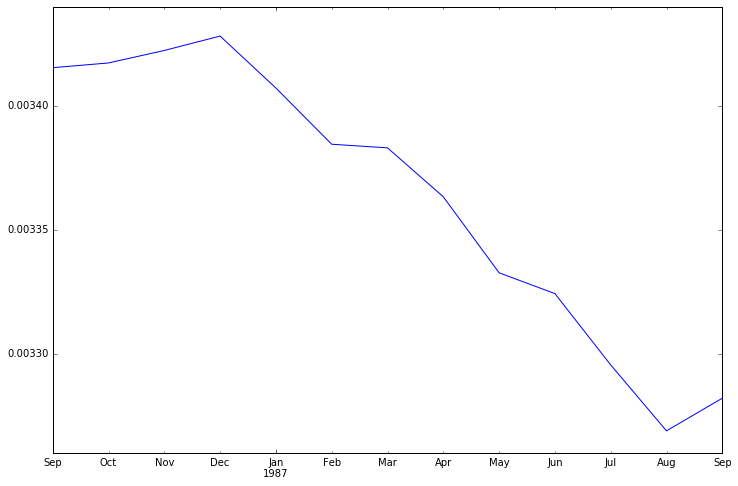

In [54]:
forecast = results.predict(start = 2200, end= 2212, dynamic= True)  
forecast.plot(figsize=(12, 8))
#serie_final.plot(figsize=(12, 8))

And here is the comparaison with the original serie.

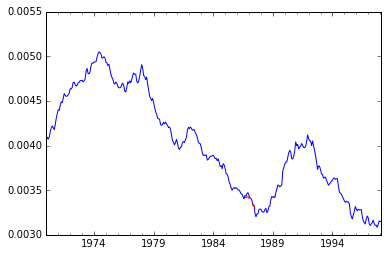

In [55]:
ax = rolmean[2000:].plot()
ax = forecast.plot(ax=ax, style='r--', label='Dynamic Prediction');

We can do the same for another year.

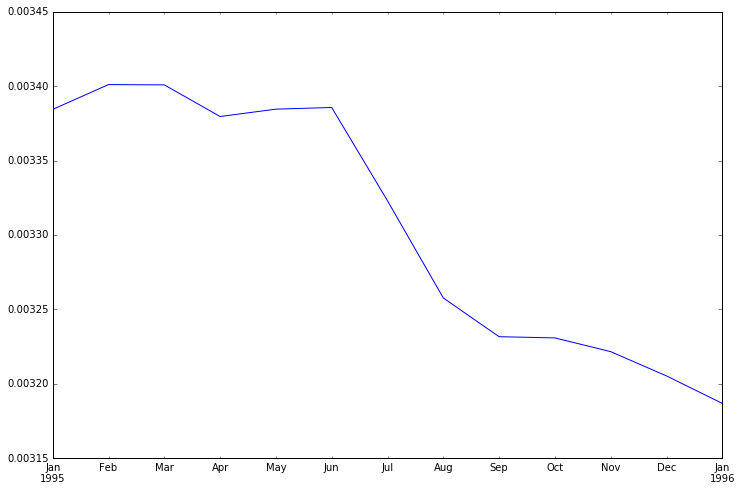

In [56]:
forecast_2 = results.predict(start = 2300, end= 2312, dynamic= True)  
forecast_2.plot(figsize=(12, 8))
#serie_final.plot(figsize=(12, 8))

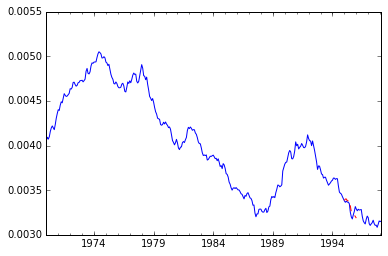

In [57]:
ax = rolmean[2000:].plot()
ax = forecast_2.plot(ax=ax, style='r--', label='Dynamic Prediction');

We can see that the model can predict the original time serie relatively well.